In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import seaborn as sns
sns.set()

pluto = pd.read_csv('pluto.csv')

In [2]:
features = pluto[['311','hmc_v','hmc_c', 'dev','dc','dv','AssessTot','UnitsRes','LotArea']]
features.columns = ['311 Complaints','HMC Violations','HMC Complaints', 'DOB ECB Violations','DOB Complaints','DOB Violations','AssessTot','UnitsRes','LotArea']
target = pluto['has_lit']

X_train1, X_test, y_train1, y_test = train_test_split(features, target, test_size=.33, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=.33, random_state=10)

In [6]:
pluto.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,CD,CT2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,...,PFIRM15_FLAG,lits,has_lit,311,hmc_v,hmc_c,dev,dev_agg,dc,dv
0,0,0,0,501,3.0,31.0,49.0,10301.0,L078,120.0,...,0.0,0,0,10,0,0,5,0,0,11
1,1,1,1,501,3.0,31.0,49.0,10301.0,L078,120.0,...,0.0,0,0,0,0,0,0,0,0,0
2,2,2,2,501,3.0,31.0,49.0,10301.0,L078,120.0,...,0.0,0,0,0,0,0,0,0,0,0
3,3,3,3,501,3.0,31.0,49.0,10301.0,L078,120.0,...,0.0,0,0,0,0,0,0,0,0,0
4,4,4,4,501,3.0,31.0,49.0,10301.0,L078,120.0,...,0.0,0,0,0,0,0,0,0,0,0


In [8]:
pluto['BBL'].value_counts()

3007320062    1
3062340012    1
3064050025    1
3005340004    1
4079090016    1
3025630064    1
5045750110    1
4131400026    1
5012210007    1
4062660012    1
4028660048    1
3089140046    1
5052680200    1
4104180037    1
1012980036    1
5011210044    1
3026250050    1
3066100032    1
4028830013    1
3068810029    1
3026860024    1
2051230006    1
3085130036    1
4082720023    1
1013150001    1
5042290114    1
4102130030    1
3082910064    1
3057470061    1
2045210025    1
             ..
2029600147    1
5021180101    1
4023570012    1
2044440001    1
3082520004    1
4101660159    1
4028270052    1
5011820029    1
4142040036    1
4038450001    1
4126830073    1
4036630006    1
4035910027    1
4131010034    1
4091160048    1
5072670189    1
4071710014    1
2050670051    1
4116420038    1
4142551724    1
3042670042    1
1008410071    1
3065710036    1
3007000017    1
1006360014    1
5014810001    1
3057660070    1
5011230012    1
3019630024    1
3087020038    1
Name: BBL, Length: 85921

Making sure each entry has a distinct BBL

In [3]:
xg = XGBClassifier()
xg.fit(X_train,y_train)
f1_score(y_train,xg.predict(X_train))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6089428005887428

In [29]:
f1_score(y_val,xg.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6031795511221946

In [30]:
roc_auc_score(y_val,xg.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7441328202733577

Text(0.5,0,'False Positive Rate')

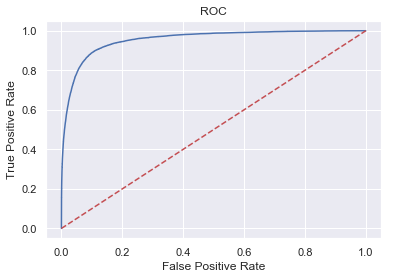

In [6]:
fpr, tpr, _ = roc_curve(y_val, xg.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr)

plt.title('ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5,1,'Model Features')

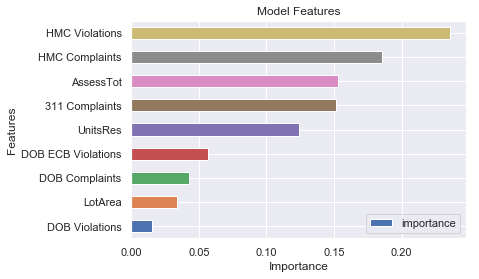

In [7]:
feat_imps = list(zip(features,xg.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Model Features')

This model actually performs pretty well! The coefficients make sense as the more complaints and violations a house has, the more likely there are issues with the landlord.

In [3]:
xgt = XGBClassifier(n_estimators=30000,
                    max_depth=4,
                    objective='binary:logistic', #new objective
                    learning_rate=.05, 
                    subsample=.8,
                    min_child_weight=3,
                    colsample_bytree=.8
                    )
eval_set=[(X_train,y_train),(X_val,y_val)]
xgt.fit(X_train,y_train,
       eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=30000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Text(0.5,0,'False Positive Rate')

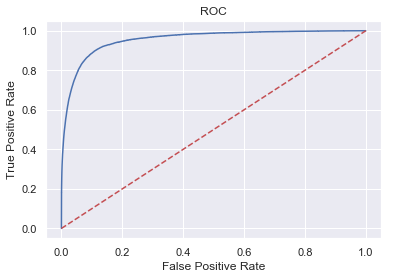

In [5]:
fpr, tpr, _ = roc_curve(y_test, xgt.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

plt.title('ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [5]:
f1_score(y_train,xgt.predict(X_train))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6254663587218598

In [6]:
f1_score(y_val,xgt.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6065888456549934

In [8]:
roc_auc_score(y_train,xgt.predict(X_train))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7545637379079594

In [9]:
roc_auc_score(y_val,xgt.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7459318825931889

Text(0.5,1,'Model Features')

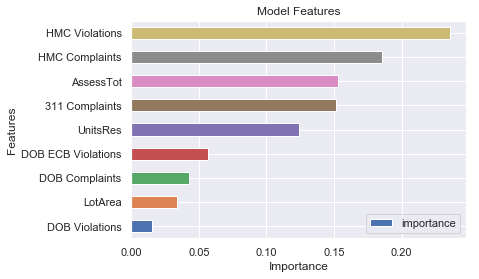

In [13]:
feat_imps = list(zip(features,xg.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Model Features')

This does better but not a ton better than the other one.

Text(0.5,0,'False Positive Rate')

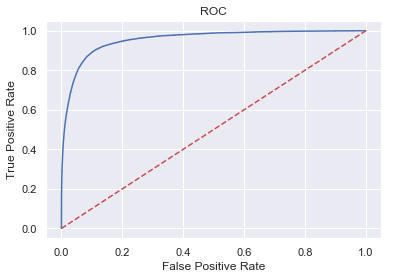

In [14]:
fpr, tpr, _ = roc_curve(y_val, xgt.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr)

plt.title('ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [36]:
f1_score(y_test,xgt.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6054595715272979

In [16]:
roc_auc_score(y_test,xg.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.744022050058656

In [17]:
from sklearn.metrics import precision_score

In [37]:
precision_score(y_train,xgt.predict(X_train))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.788608

In [38]:
precision_score(y_val,xgt.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7665879884605298

About 75% of the predicted positives are actually housing litigations.

In [20]:
from sklearn.metrics import recall_score

In [39]:
recall_score(y_train,xgt.predict(X_train))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5182537012113055

In [40]:
recall_score(y_val,xgt.predict(X_val))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.501845651987295

It only captures about 50% of all litigations.

In [10]:
f1_score(y_test,xgt.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6054595715272979

In [15]:
precision_score(y_test,xgt.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7633527925416049

In [13]:
roc_auc_score(y_test,xgt.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7457408572131684

In [4]:
from sklearn.metrics import precision_score

In [10]:
from sklearn.metrics import recall_score

In [11]:
recall_score(y_test,xgt.predict(X_test))

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5016892859187998